In [1]:
#!/usr/bin/env python

from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input
import numpy as np
import pandas as pd

hh101 = pd.read_csv("C:\\Users\Kiki\Downloads\PhD Data\hh101\hh101\hh101.rawdata.txt", header = None, sep='\t', names = ['Time', 'ID', 'Object', 'Room', 'Item', 'Sensor'])
#hh101 = pd.read_csv("C:\\Users\Kiki\Downloads\PhD Data\hh101\hh101\hh101.csv", header = None, names = ['timestamp', 'entity_id', 'attribute_name', 'value'])

print(hh101.columns)
print(hh101.head())
hh101 = hh101.drop(['Time'], axis=1)
#hh101 = hh101.drop(['timestamp'], axis=1)
#hh101 = hh101.replace(['TRUE', 'FALSE'],[1, 0])

samples = []
for row in hh101.iterrows():
    index, data = row
    samples.append(data.tolist())

max_words = 20000
maxlen = 3


# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
print(data)
'''
log = pd.read_csv("C:\\Users\Kiki\Downloads\PhD Data\hh102\hh102\hh102.ann.features.csv")
#log = pd.read_csv(log, names=["IP", "Time", "Request", "Response"])
print(log.columns)
log = log.drop(['activity'], axis=1)

samples = []
for row in log.iterrows():
    index, data = row
    samples.append(data.tolist())

max_words = 20000
maxlen = 3

# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
print(data)
'''

# Split data into training and test set. 
training_samples = int(len(samples) * 0.80)
test_samples = int(len(samples) * 0.20)

x = data[:training_samples]
x_test = data[training_samples: training_samples + test_samples]

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='log_model-testing.h5',
    monitor='val_loss',
    save_best_only=True
    )
]

# Create model.
input_dim = x.shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(3, activation='relu')(input)
encode = Dense(1, activation='relu')(encode)

decode = Dense(2, activation='relu')(encode)
decode = Dense(3, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(x, x,
        epochs=40,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(x_test, x_test),
        shuffle=True
        )

Index(['timestamp', 'entity_id', 'attribute_name', 'value'], dtype='object')
                 timestamp               entity_id attribute_name value
0  2021-07-18 12:54:45.196  6CXWeD29rTaM8k3wyPKeeg       position  true
1  2021-07-18 12:54:45.247  2Qlk9aPijmCaAqK8tMtf74    temperature    78
2  2021-07-18 12:54:45.302  2Qlk9aPijmCaAqK8tMtf74        battery    85
3  2021-07-18 12:54:45.399  42ZtDmrqrjNy6jrMWIXWlO    temperature    25
4  2021-07-18 12:54:45.472  42ZtDmrqrjNy6jrMWIXWlO        battery    82
Found 132 unique tokens.
[[ 58   6   3]
 [ 84  29 121]
 [ 84  44 111]
 ...
 [  9   4  74]
 [ 14   4  53]
 [  8   4  71]]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 3)                 12        
                         

In [6]:
import pandas as pd
from numpy import vstack
#import seaborn as sns

# Combined x and x_test.
new_x = vstack([x, x_test])

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)


error_df.describe()

,reconstruction_error
count,1.663230e+06
mean,4.103564e+02
std,7.921680e+02
min,1.233333e+01
25%,1.500000e+01
50%,2.833333e+01
75%,5.176667e+02
max,9.015000e+03


(array([1.506494e+06, 1.043160e+05, 3.977000e+04, 6.691000e+03,
        4.144000e+03, 1.456000e+03, 3.590000e+02]),
 array([  12.33333333, 1298.42857143, 2584.52380952, 3870.61904762,
        5156.71428571, 6442.80952381, 7728.9047619 , 9015.        ]),
 <BarContainer object of 7 artists>)

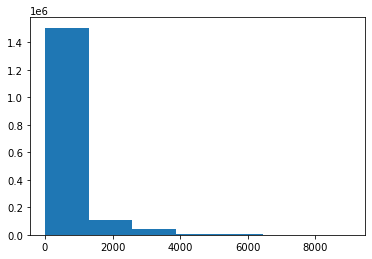

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

#sns.histplot(error_df.reconstruction_error.values, binwidth=8)

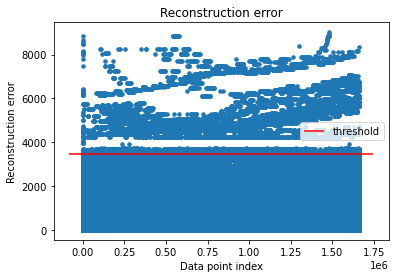

temperature
7P6GpxIomHcfKP1MZpdI3q
78
----------------------------------
battery
7P6GpxIomHcfKP1MZpdI3q
85
----------------------------------
battery
2cCL4CyTHQ3hXU1AUigzsM
82
----------------------------------
true
position
4uAQxNoZe3Vl3wEl5VAJI1
----------------------------------
71W6rKSdOXRuJTG8eYmO27
battery
100
----------------------------------
38Z88xbdQh1MutZupTgrus
battery
100
----------------------------------
3Ge72Lb61T2Yrrnj7rHKN0
battery
100
----------------------------------
2QpbQO34UZeLqX2DMfFNvt
battery
100
----------------------------------
3NtIg6iWXBnRlPLVouPyO6
battery
99
----------------------------------
6TcIAFzYSgpwcByD2CFMY5
battery
100
----------------------------------
27kTFz7Lq4xpKHNFMsuSgT
battery
100
----------------------------------
5DBHIfps52IPRa8EirsD6x
battery
100
----------------------------------
4qV5f8jcBDVtvPBty2NYtD
battery
100
----------------------------------
6zknLOyttl8U3KZ6FstT6j
battery
100
----------------------------------
brightness
5Kcixou

In [8]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])
  
for x in output:
    for key, value in word_index.items():
        if value == x[2]:
            print(key)
        if value == x[1]:
            print(key)
        if value == x[0]:
            print(key)
    print('----------------------------------')


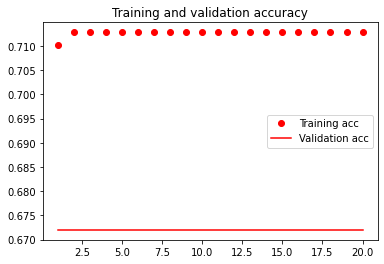

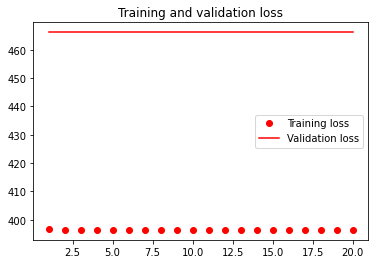

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()